In [143]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
import time
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from collections import defaultdict, OrderedDict
from pymicro.view.vol_utils import compute_affine_transform
from pprint import pprint
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.file_location import FileLocationManager
from utilities.utilities_cvat_neuroglancer import get_structure_number, NumpyToNeuroglancer, get_segment_properties

In [144]:
# install these
#https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/pointset_registration.html
from pymicro.view.vol_utils import compute_affine_transform
#https://pypi.org/project/affine6p/
import affine6p
#https://github.com/jewettaij/superpose3d
from superpose3d import Superpose3D

In [10]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, 'MD589_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations.head()
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
#structures = ['DC', 'LC','SC', '5N', '7n']
#structures = ['DC', 'LC','SC', '5N', '7n', '10N', '3N', '4N' , '6N', '7N', 'Amb']

# SC is the only singular structure
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
#df = df.loc[df['name'].isin(structures)]
#df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

,name,section,side,vertices
1132,10N,200,L,"[[28574.87597063, 13718.97833276], [28644.2861..."
52,10N,201,L,"[[29477.99943241, 15023.91281516], [29375.9413..."
1773,10N,203,L,"[[28402.11271331, 13609.03075224], [28259.4471..."
709,10N,204,L,"[[27941.31022435, 14065.37228976], [27815.0453..."
1748,10N,205,L,"[[28299.37363286, 13004.51644074], [28155.6736..."


In [128]:
# these are the 5 structures Beth suggested for getting
# enough that were spread out.
centers = {}
structures = ['DC', 'LC','SC', '5N']
section_structure_vertices = defaultdict(dict)
SC = df.loc[(df['name'] == "SC")]
first_section = SC['section'].min()
last_section = SC['section'].max()
midsection = int(round(((last_section + first_section) / 2)))
point_array = SC['vertices'].loc[SC['section'] == midsection].values
section_structure_vertices[midsection]['SC'] = point_array[0]
cx, cy = np.mean(point_array[0], axis=0)    
centers['SC'] = [cx, cy, midsection]

structures.remove('SC')
for structure in structures:
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "L")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    try:
        midsection = int(round(((last_section + first_section) / 2)))
    except: 
        print('Error with', structure)
        break
    structure_name = structure + "_L"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [cx, cy, midsection]
    
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "R")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section - first_section) / 2) + first_section))
    structure_name = structure + "_R"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [cx, cy, midsection]


In [35]:
pprint(centers)

{'10N_L': [30928.49438599714, 12939.677824158094, 210],
 '10N_R': [29284.49554866147, 13339.540536054074, 242],
 '4N_L': [24976.742385259997, 9685.320856475, 210],
 '4N_R': [24516.55179962143, 9154.861612245713, 236],
 '5N_L': [23789.984501544375, 13025.174081591875, 160],
 '5N_R': [20805.414639021943, 14163.355691957777, 298],
 '7N_L': [23184.71446623, 15964.358564491615, 174],
 '7N_R': [23525.73793603972, 15117.485091564571, 296],
 '7n_L': [20987.553460092142, 18404.810023741426, 177],
 '7n_R': [24554.23633658875, 13910.6602304075, 284],
 'Amb_L': [25777.11256108571, 15152.709144375, 167],
 'Amb_R': [25184.94247019933, 14794.196115586003, 296],
 'DC_L': [24481.971490631582, 11984.58023668316, 134],
 'DC_R': [20423.754452355664, 11736.014030692337, 330],
 'LC_L': [25290.18582962385, 11749.672587382307, 180],
 'LC_R': [24894.30149961837, 12078.56676300372, 268],
 'Pn_L': [20986.433685970915, 14907.131608333335, 200],
 'Pn_R': [19142.43337585326, 14778.245969858139, 270],
 'SC': [24226.

In [129]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 1
colors = {}
colors['SC'] = (255,0,255)

colors['DC_L'] = (0,0,0)
colors['LC_L'] = (255,0,0)
colors['SC_L'] = (255,0,255)
colors['5N_L'] = (0,255,255)
colors['7n_L'] = (100,10,255)
colors['DC_R'] = (0,0,0)
colors['LC_R'] = (255,0,0)
colors['SC_R'] = (255,0,255)
colors['5N_R'] = (0,255,255)
colors['7n_R'] = (100,10,255)
# create a fake random distance away from the original structures
rand_offset = np.random.randint(75,150)
offsets = {}
section_images = {}
points = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)        
        points = points // SCALE
        
        points_diff = np.rint(points + rand_offset)
        points_diff = points_diff.astype(np.int32)
        cxoff, cyoff = np.min(points_diff, axis=0)
        offsets[structure] = [int(round(cxoff*SCALE)), int(round(cyoff*SCALE)), section]
        
        #cv2.polylines(img, [points_diff], isClosed=True, color=(0,0,0), thickness=5)
        cx = centers[structure][0] // SCALE
        cy = centers[structure][1] // SCALE
        
        cv2.circle(img, (int(cx),int(cy)), 5, (0,0,0), -1)
            
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (int(cx),int(cy)), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
            
    section_images[section] = img

100%|██████████| 447/447 [00:04<00:00, 94.05it/s] 


In [ ]:
centers

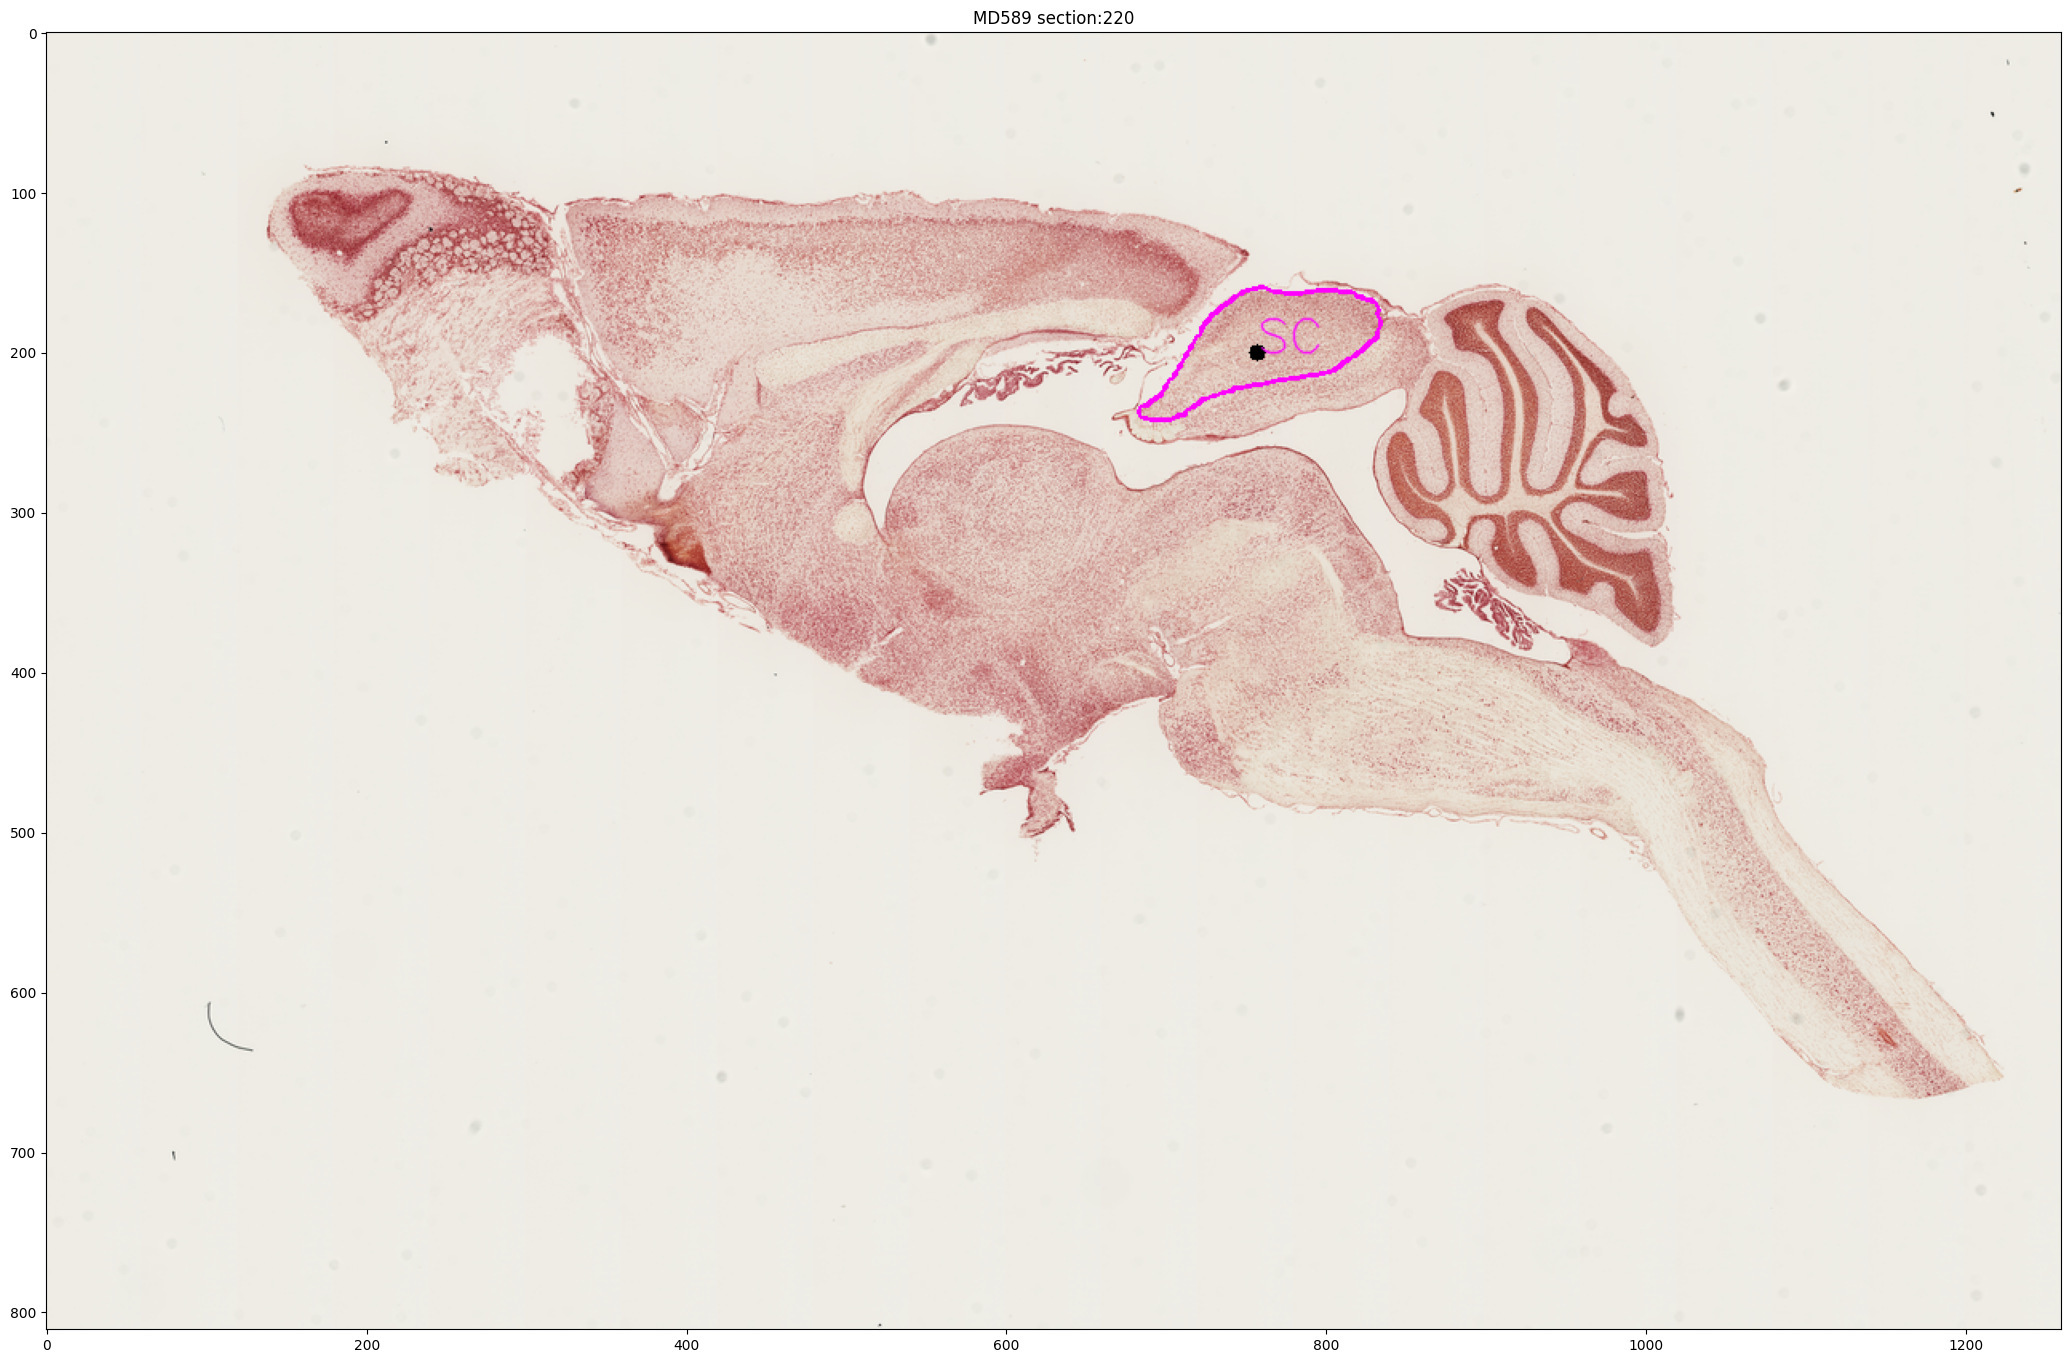

In [130]:
# this shows the real structure, it's center of mass and a fake offsetted structure
structure_midpoints = [134,160,177,180,220,268,284,298,330]
section = structure_midpoints[4]
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="gray")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [ ]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
print(origin_centroid, fitted_centroid, other_structure)

In [ ]:
# Pad the data with ones, so that our transformation can do translations too
n = origin.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(origin)
Y = pad(fitted)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, res, rank, s = np.linalg.lstsq(X, Y)

transform = lambda x: unpad(np.dot(pad(x), A))

print("Target:", fitted)
print("Result:", transform(origin))
print("Max error:", np.abs(fitted - transform(origin)).max())

In [ ]:
def Affine_Fit( from_pts, to_pts ):
    """Fit an affine transformation to given point sets.
      More precisely: solve (least squares fit) matrix 'A'and 't' from
      'p ~= A*q+t', given vectors 'p' and 'q'.
      Works with arbitrary dimensional vectors (2d, 3d, 4d...).

      Written by Jarno Elonen <elonen@iki.fi> in 2007.
      Placed in Public Domain.

      Based on paper "Fitting affine and orthogonal transformations
      between two sets of points, by Helmuth Späth (2003)."""

    q = from_pts
    p = to_pts
    if len(q) != len(p) or len(q)<1:
        print("from_pts and to_pts must be of same size.")
        return false

    dim = len(q[0]) # num of dimensions
    if len(q) < dim:
        print("Too few points => under-determined system.")
        return false

    # Make an empty (dim) x (dim+1) matrix and fill it
    c = [[0.0 for a in range(dim)] for i in range(dim+1)]
    for j in range(dim):
        for k in range(dim+1):
            for i in range(len(q)):
                qt = list(q[i]) + [1]
                c[k][j] += qt[k] * p[i][j]

    # Make an empty (dim+1) x (dim+1) matrix and fill it
    Q = [[0.0 for a in range(dim)] + [0] for i in range(dim+1)]
    for qi in q:
        qt = list(qi) + [1]
        for i in range(dim+1):
            for j in range(dim+1):
                Q[i][j] += qt[i] * qt[j]

    # Ultra simple linear system solver. Replace this if you need speed.
    def gauss_jordan(m, eps = 1.0/(10**10)):
      """Puts given matrix (2D array) into the Reduced Row Echelon Form.
         Returns True if successful, False if 'm' is singular.
         NOTE: make sure all the matrix items support fractions! Int matrix will NOT work!
         Written by Jarno Elonen in April 2005, released into Public Domain"""
      (h, w) = (len(m), len(m[0]))
      for y in range(0,h):
        maxrow = y
        for y2 in range(y+1, h):    # Find max pivot
          if abs(m[y2][y]) > abs(m[maxrow][y]):
            maxrow = y2
        (m[y], m[maxrow]) = (m[maxrow], m[y])
        if abs(m[y][y]) <= eps:     # Singular?
          return False
        for y2 in range(y+1, h):    # Eliminate column y
          c = m[y2][y] / m[y][y]
          for x in range(y, w):
            m[y2][x] -= m[y][x] * c
      for y in range(h-1, 0-1, -1): # Backsubstitute
        c  = m[y][y]
        for y2 in range(0,y):
          for x in range(w-1, y-1, -1):
            m[y2][x] -=  m[y][x] * m[y2][y] / c
        m[y][y] /= c
        for x in range(h, w):       # Normalize row y
          m[y][x] /= c
      return True

    # Augement Q with c and solve Q * a' = c by Gauss-Jordan
    M = [ Q[i] + c[i] for i in range(dim+1)]
    if not gauss_jordan(M):
        print("Error: singular matrix. Points are probably coplanar.")
        return false

    # Make a result object
    class Transformation:
        """Result object that represents the transformation
           from affine fitter."""

        def To_Str(self):
            res = ""
            for j in range(dim):
                str = "x%d' = " % j
                for i in range(dim):
                    str +="x%d * %f + " % (i, M[i][j+dim+1])
                str += "%f" % M[dim][j+dim+1]
                res += str + "\n"
            return res

        def Transform(self, pt):
            res = [0.0 for a in range(dim)]
            for j in range(dim):
                for i in range(dim):
                    res[j] += pt[i] * M[i][j+dim+1]
                res[j] += M[dim][j+dim+1]
            return res
    return Transformation()

In [ ]:
fitted

In [ ]:
from_pt = origin / 32
to_pt = fitted / 32
trn = Affine_Fit(from_pt, to_pt)
print("Transformation is:")
print(trn.To_Str())

err = 0.0
for i in range(len(from_pt)):
    fp = from_pt[i]
    tp = to_pt[i]
    t = trn.Transform(fp)
    print(t)
    #print ("%s => %s ~= %s" % (fp, tuple(t), tp))
    err += ((tp[0] - t[0])**2 + (tp[1] - t[1])**2)**0.5

print("Fitting error = %f" % err)

In [ ]:
SCALE = (10 / 0.452)
SCALE = 32
MD589_centers = {'SC': [24226, 6401, 220],
     'DC_L': [24482, 11985, 134],
     'DC_R': [20424, 11736, 330],
     'LC_L': [25290, 11750, 180],
     'LC_R': [24894, 12079, 268],
     '5N_L': [23790, 13025, 160],
     '5N_R': [20805, 14163, 298],
     '7n_L': [20988, 18405, 177],
     '7n_R': [24554, 13911, 284]}
MD589_center_values = np.array(list(MD589_centers.values()), dtype=np.float32)
MD589_list = []
for value in MD589_centers.values():
    MD589_list.append((value[0]/SCALE, value[1]/SCALE, value[2]))

MD589_center_values = np.array(MD589_list)
MD589_center_values

In [ ]:
atlas_centers = {'5N_L': [460.53, 685.58, 155],
 '5N_R': [460.53, 685.58, 293],
 '7n_L': [499.04, 729.94, 172],
 '7n_R': [499.04, 729.94, 276],
 'DC_L': [580.29, 650.66, 130],
 'DC_R': [580.29, 650.66, 318],
 'LC_L': [505.55, 629.99, 182],
 'LC_R': [505.55, 629.99, 266],
 'SC': [376.87, 453.2, 226]}
atlas_center_values = np.array(list(atlas_centers.values()))
atlas_center_values

In [ ]:
A[np.abs(A) < 1e-2] = 0  # set really small values to zero
print(A)

In [ ]:
RMSD, R, T, c = Superpose3D(origin, fitted)

In [ ]:
print(other_structure)
origin_centroid + np.dot(R, other_structure - fitted_centroid)

In [ ]:
# compute the affine transform from the point set
translation, transformation = compute_affine_transform(MD589_center_values, atlas_center_values)
invt = np.linalg.inv(transformation)
offset = -np.dot(invt, translation)
#print(other_structure, origin_centroid + np.dot(transformation, other_structure - fitted_centroid))
translation

In [ ]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
colors = 'brg'
new_points = np.empty_like(origin)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')

for i in range(len(origin)):
    new_points[i] = origin_centroid + np.dot(transformation, fitted[i] - fitted_centroid)
    print('point %d will move to (%3.1f, %3.1f) to be compared with (%3.1f, %3.1f)' % (
    i, new_points[i, 0], new_points[i, 1], origin[i, 0], origin[i, 1]))
    plt.plot(new_points[i, 0], new_points[i, 1], 'x', color=colors[0], markersize=14,
             label='new points' if i == 0 else '')
    plt.plot(origin[i, 0], origin[i, 1], 'o', color=colors[1], markersize=16,
             label='origin' if i == 0 else '')
    plt.plot(fitted[i, 0], fitted[i, 1], 'v', color=colors[2], markersize=18,
             label='atlas' if i == 0 else '')
plt.legend(numpoints=1)
plt.show()


In [ ]:
fileLocationManager = FileLocationManager(animal)
atlas_name = 'atlasV7'
DATA_PATH = '/net/birdstore/Active_Atlas_Data/data_root'
ROOT_DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'
THUMBNAIL_DIR = os.path.join(ROOT_DIR, animal, 'preps', 'CH1', 'thumbnail')
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')
OUTPUT_DIR = os.path.join(fileLocationManager.neuroglancer_data, 'atlas')
os.makedirs(OUTPUT_DIR, exist_ok=True)
SCALE = 32
origin_files = sorted(os.listdir(ORIGIN_PATH))
volume_files = sorted(os.listdir(VOLUME_PATH))

structure_volume_origin = {}
for volume_filename, origin_filename in zip(volume_files, origin_files):
    structure = os.path.splitext(volume_filename)[0]
    if structure not in origin_filename:
        print(structure, origin_filename)
        break

    color = get_structure_number(structure.replace('_L', '').replace('_R', ''))

    origin = np.loadtxt(os.path.join(ORIGIN_PATH, origin_filename))
    volume = np.load(os.path.join(VOLUME_PATH, volume_filename))

    volume = np.rot90(volume, axes=(0, 1))
    volume = np.flip(volume, axis=0)
    volume[volume > 0.8] = color
    volume = volume.astype(np.uint8)

    structure_volume_origin[structure] = (volume, origin)
sqlController = SqlController(animal)
resolution = sqlController.scan_run.resolution
aligned_shape = np.array((sqlController.scan_run.width, sqlController.scan_run.height))
z_length = len(os.listdir(THUMBNAIL_DIR))

downsampled_aligned_shape = np.round(aligned_shape / SCALE).astype(int)

x_length = downsampled_aligned_shape[1]
y_length = downsampled_aligned_shape[0]

atlasV7_volume = np.zeros((x_length, y_length, z_length), dtype=np.uint32)

min_structures = {'SC': [21868, 5119, 220],
                  'DC_L': [24103, 11618, 134],
                  'DC_R': [19870, 11287, 330],
                  'LC_L': [24746, 11178, 180],
                  'LC_R': [24013, 11621, 268],
                  '5N_L': [23105, 12133, 160],
                  '5N_R': [20205, 13373, 298],
                  '7n_L': [20611, 17991, 177],
                  '7n_R': [24218, 13615, 284]}

mean_structures = {'SC': [24226, 6401, 220],
                   'DC_L': [24482, 11985, 134],
                   'DC_R': [20424, 11736, 330],
                   'LC_L': [25290, 11750, 180],
                   'LC_R': [24894, 12079, 268],
                   '5N_L': [23790, 13025, 160],
                   '5N_R': [20805, 14163, 298],
                   '7n_L': [20988, 18405, 177],
                   '7n_R': [24554, 13911, 284]}

animal_origin = {}
for structure, origin in mean_structures.items():
    animal_origin[structure] = [mean_structures[structure][1]/SCALE,
                                    mean_structures[structure][0]/SCALE,
                                    mean_structures[structure][2]]

atlas_origin = {}
atlas_all_origins = {}

print('animal_origin', animal_origin)
# 1st loop to fill dictionarys with data
for structure, (volume, origin) in sorted(structure_volume_origin.items()):
    x, y, z = origin
    x_start = int(x) + x_length // 2
    y_start = int(y) + y_length // 2
    z_start = int(z) // 2 + z_length // 2
    x_end = x_start + volume.shape[0]
    y_end = y_start + volume.shape[1]
    z_end = z_start + (volume.shape[2] + 1) // 2
    midx = round((x_end + x_start) / 2)
    midy = round((y_end + y_start) / 2)
    midz = round((z_end + z_start) / 2)
    #print(structure,'centroid', midx,midy,midz)

    if structure in animal_origin.keys():
        atlas_origin[structure] = [midx, midy, midz]

    atlas_all_origins[structure] = [midx, midy, midz]

print('atlas_origin', atlas_origin)
print()

atlas_origin_array = np.array(list(atlas_origin.values()), dtype=np.float32)
animal_origin_array = np.array(list(animal_origin.values()), dtype=np.float32)
animal_centroid = np.mean(animal_origin_array, axis=0)
atlas_centroid = np.mean(atlas_origin_array, axis=0)
print('volume centriods', animal_centroid, atlas_centroid)
print('animal_origin_array', animal_origin_array.shape)
print(animal_origin_array)
print('atlas_origin_array', atlas_origin_array.shape)
print(atlas_origin_array)

In [ ]:
from pprint import pprint
pprint(animal_origin_array)

In [ ]:
RMSD, R, T, c = Superpose3D(animal_origin_array, atlas_origin_array, allow_rescale=True)

In [ ]:
T

In [ ]:
# basic least squares
n = animal_origin_array.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]
X = pad(animal_origin_array)
Y = pad(atlas_origin_array)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
transform = lambda x: unpad(np.dot(pad(x), A))
#A[np.abs(A) < 1e-10] = 0
print(A)

In [ ]:
a = X.T
#np.vstack([animal_origin_array, np.ones(len(animal_origin_array))])
#a = np.vstack([animal_origin_array, np.ones(len(animal_origin_array))]).T
Ap = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
print(Ap)

In [ ]:
App = np.linalg.lstsq(X, Y, rcond=None)[0]
print(App)

In [ ]:
animal_origin = {'SC': [200.03125, 757.0625, 220], 'DC_L': [374.53125, 765.0625, 134], 'DC_R': [366.75, 638.25, 330]}
atlas_origin =  {'SC': [377.0, 454.0, 226], 'DC_L': [580.0, 651.0, 131], 'DC_R': [580.0, 651.0, 318]}
#primary = np.array(list(animal_origin.values()), dtype=np.float32)
#secondary = np.array(list(atlas_origin.values()), dtype=np.float32)
primary = animal_origin_array
secondary = atlas_origin_array

In [ ]:
[1 for x in range(primary.shape[0])]


In [ ]:
def solve_affine(rbar, rfit):
    x = np.transpose(np.matrix(rbar))
    y = np.transpose(np.matrix(rfit))
    # add ones on the bottom of x and y
    rows = rbar.shape[0]
    bottom = [1 for x in range(rows)]
    x = np.vstack((x,bottom))
    y = np.vstack((y,bottom))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is
    return lambda x: (A2*np.vstack((np.matrix(x).reshape(3,1),1)))[0:rows,:]


In [ ]:
n = primary.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(primary)
Y = pad(secondary)
# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
transform = lambda x: unpad(np.dot(pad(x), A))
print("Target:")
print(secondary)
print("Result:")
print(transform(primary))
print("Max error:", np.abs(secondary - transform(primary)).max())

In [ ]:
var7nl = np.array([446,676,135])
print(transformFn(var7nl))
print(var7nl.shape)
var7nl = np.vstack((var7nl,[1,1,1]))
print(transform(var7nl))


In [ ]:
resolution = 0.452
SCALE = (10 / resolution)
MD589 = np.array([[407.03125, 743.4375 , 160.     ],
       [442.59375, 650.15625, 298.     ],
       [575.15625, 655.875  , 177.     ],
       [434.71875, 767.3125 , 284.     ],
       [374.53125, 765.0625 , 134.     ],
       [366.75   , 638.25   , 330.     ],
       [367.1875 , 790.3125 , 180.     ],
       [377.46875, 777.9375 , 268.     ],
       [200.03125, 757.0625 , 220.     ]])
ATLAS = np.array([[460.53141394, 685.08009809, 155.37759879],
       [460.53141394, 685.08009809, 292.62240121],
       [499.04059535, 729.43840451, 172.21316875],
       [499.04059535, 729.43840451, 275.78683125],
       [580.29029567, 650.15523228, 130.34657231],
       [580.29029567, 650.15523228, 317.65342769],
       [505.54820385, 629.48921799, 182.33057907],
       [505.54820385, 629.48921799, 265.66942093],
       [376.87494713, 452.70218382, 225.5       ]])


In [ ]:
pprint(MD589)
pprint(ATLAS)

In [ ]:
np.linalg.norm(MD589 - ATLAS)

In [ ]:
0.452 * 1000 / 0.03125

In [ ]:
SCALE_MD589 = 0.452 * 1000 / 0.03125 # 14464 in nm
SCALE_ATLAS = 0.452 * 1000
a = ATLAS * (32 - (10/0.452))
pprint(a)

In [ ]:
colors = 'brgmkbrgmkbrgmkbrgmk'

n = ATLAS.shape[0]
for i in range(n):
    plt.plot(MD589[i, 0], MD589[i, 1], 'o', color='b', markersize=15, markeredgecolor='none',
         label='MD589' if i == 0 else '')
    plt.plot(ATLAS[i, 0], ATLAS[i, 1], 'o', color='c', markersize=10, markeredgecolor='none',
         label='ATLAS' if i == 0 else '')
plt.grid()
plt.axis([0, 1000, 0, 1000])
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(numpoints=1)
#plt.savefig('pointset_registration_1.png', format='png')
plt.show()

In [ ]:
md589_centroid = np.mean(MD589, axis=0)
atlas_centroid = np.mean(ATLAS, axis=0)
print('MD589 centroid', md589_centroid)
print('Atlas centroid', atlas_centroid)
t = md589_centroid - atlas_centroid
print('distance of centroids', t, type(t), t.shape)
pprint(MD589)
pprint(ATLAS)


In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
md589_centroid = np.mean(MD589, axis=0)
atlas_centroid = np.mean(ATLAS, axis=0)
print('MD589 centroid', md589_centroid)
print('Atlas centroid', atlas_centroid)
print('distance of centroids', md589_centroid - atlas_centroid)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')

# Creating figure
ax = plt.axes(projection ="3d")
ax.scatter3D(MD589[:,0],MD589[:,1],MD589[:,2], color='green', s=500);
ax.scatter3D(md589_centroid[0],md589_centroid[1],md589_centroid[2], color='g', s=2000)
#ax.plot3D(MD589[:,0],MD589[:,1],MD589[:,2], color='g')

ax.scatter3D(ATLAS[:,0],ATLAS[:,1],ATLAS[:,2], color='red', s=500);
ax.scatter3D(atlas_centroid[0],atlas_centroid[1],atlas_centroid[2], color='r', s=2000)
#ax.plot3D(ATLAS[:,0],ATLAS[:,1],ATLAS[:,2], color='r')
plt.show()

In [ ]:
P = np.array([[1,2],[2,3],[-2,1],[-1, -6]])         
Q =  np.array([[ 7.5391,4.3455], [12.9796,5.8897],[-4.5847,5.3159],[-15.9340,-15.5511]])
pprint(P)
pprint(Q)

In [ ]:
X = np.linalg.inv(P.T @ P) @ P.T @ Q

In [ ]:
U,S,V = np.linalg.svd(X)
R = V @ U.T

In [ ]:
results

U = -0.7317   -0.6816
    -0.6816    0.7317

S =  4  0
     0  3

V = -0.9689   -0.2474
    -0.2474    0.9689
Here SVD has properly reconstructed all manipulations I performed on matrix P to get matrix Q: 
rotate by the angle 0.75, 
scale X axis by 4, 
scale Y axis by 3, 
rotate by the angle -0.25.
[[cos,-sin],[sin, cos]]

In [138]:
COM = np.array([[ 774.69517414, 1401.29351924,  210.        ],
       [ 769.58776556, 1394.50232967,  242.        ],
       [ 614.9899627 , 1140.77350662,  210.        ],
       [ 613.46128767, 1140.47612813,  236.        ],
       [ 743.47211091, 1169.05003638,  160.        ],
       [ 727.22500949, 1157.92999524,  298.        ],
       [ 857.737444  , 1234.64784939,  174.        ],
       [ 838.35395234, 1230.66647709,  296.        ],
       [ 768.23243683, 1216.80832688,  177.        ],
       [ 754.30814296, 1211.51131709,  284.        ],
       [ 853.83787979, 1312.74242576,  167.        ],
       [ 826.7564618 , 1306.34794541,  296.        ],
       [ 703.31764093, 1300.15711224,  134.        ],
       [ 676.19487381, 1289.06966717,  330.        ],
       [ 684.64382852, 1220.11745788,  180.        ],
       [ 674.80723166, 1218.21277782,  268.        ],
       [ 811.27177385, 1040.46693715,  200.        ],
       [ 811.15423197, 1042.63581447,  270.        ],
       [ 458.18699698, 1128.93206941,  220.        ],
       [ 852.34580966, 1139.50512692,  212.        ],
       [ 847.83709351, 1136.44194457,  262.        ]])
ATLAS = np.array([[ 944.81074091, 1050.73146956,  209.42885577],
       [ 944.81074091, 1050.73146956,  238.57114423],
       [ 631.86454699,  885.43515455,  211.70657973],
       [ 631.86454699,  885.43515455,  236.29342027],
       [ 686.53141394,  990.08009809,  155.37759879],
       [ 686.53141394,  990.08009809,  292.62240121],
       [ 764.02028024, 1107.51534472,  165.92725783],
       [ 764.02028024, 1107.51534472,  282.07274217],
       [ 725.04059535, 1034.43840451,  172.21316875],
       [ 725.04059535, 1034.43840451,  275.78683125],
       [ 849.15475746, 1092.68263642,  161.86878073],
       [ 849.15475746, 1092.68263642,  286.13121927],
       [ 806.29029567,  955.15523228,  130.34657231],
       [ 806.29029567,  955.15523228,  317.65342769],
       [ 731.54820385,  934.48921799,  182.33057907],
       [ 731.54820385,  934.48921799,  265.66942093],
       [ 568.6688014 , 1079.04472307,  192.4868589 ],
       [ 568.6688014 , 1079.04472307,  255.5131411 ],
       [ 602.87494713,  757.70218382,  225.5       ],
       [ 662.59306613, 1107.66485079,  199.28108419],
       [ 662.59306613, 1107.66485079,  248.71891581]])


In [155]:
RMSD, R, T, c = Superpose3D(COM, ATLAS)
arr = np.array([662, 1107,  248])
R@arr + T

array([ 836.11037135, 1134.23749727,  208.83691904])

In [156]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [162]:
T, distances, i = icp(COM, ATLAS)
T = T[0:3,0:3]

Vr = np.array([[np.cos(T[0][0]), -np.sin(T[0][1]), 0],
               [np.sin(T[1][0]), np.cos(T[1][1]), 0],
               [0, 0, 1]])

#arr = np.reshape(ATLAS, (3,21))
Vr * ATLAS

ValueError: operands could not be broadcast together with shapes (3,3) (21,3) 

In [134]:
# Constants
N = COM.shape[0]                                    # number of random points in the dataset
num_tests = 1                             # number of test iterations
dim = 3                                     # number of dimensions of the points
noise_sigma = 1                           # standard deviation error to be added
translation = .1                            # max translation of the test set
rotation = .1                               # max rotation (radians) of the test set


def rotation_matrix(axis, theta):
    axis = axis/np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis*np.sin(theta/2.)

    return np.array([[a*a+b*b-c*c-d*d, 2*(b*c-a*d), 2*(b*d+a*c)],
                  [2*(b*c+a*d), a*a+c*c-b*b-d*d, 2*(c*d-a*b)],
                  [2*(b*d-a*c), 2*(c*d+a*b), a*a+d*d-b*b-c*c]])


def test_best_fit():

    # Generate a random dataset
    #A = np.random.rand(N, dim)
    A = COM
    B = ATLAS
    total_time = 0

    for i in range(num_tests):

        #B = np.copy(A)

        # Translate
        #t = np.random.rand(dim)*translation
        #B += t

        # Rotate
        #R = rotation_matrix(np.random.rand(dim), np.random.rand()*rotation)
        #B = np.dot(R, B.T).T

        # Add noise
        #B += np.random.randn(N, dim) * noise_sigma

        # Find best fit transform
        start = time.time()
        T, R1, t1 = best_fit_transform(B, A)
        total_time += time.time() - start

        # Make C a homogeneous representation of B
        C = np.ones((N, 4))
        C[:,0:3] = B

        # Transform C
        C = np.dot(T, C.T).T

        print('T should transform B (or C) to A',np.allclose(C[:,0:3], A, atol=6*noise_sigma)) # T should transform B (or C) to A
        print('t and t1 should be inverses',np.allclose(-t1, t, atol=6*noise_sigma))      # t and t1 should be inverses
        print('R and R1 should be inverses',np.allclose(R1.T, R, atol=6*noise_sigma))     # R and R1 should be inverses

    print('best fit time: {:.3}'.format(total_time/num_tests))

    return


def test_icp():

    # Generate a random dataset
    #A = np.random.rand(N, dim)
    A = COM
    B = ATLAS

    total_time = 0

    for i in range(num_tests):

        #B = np.copy(A)

        # Translate
        #t = np.random.rand(dim)*translation
        #B += t

        # Rotate
        #R = rotation_matrix(np.random.rand(dim), np.random.rand() * rotation)
        #B = np.dot(R, B.T).T

        # Add noise
        #B += np.random.randn(N, dim) * noise_sigma

        # Shuffle to disrupt correspondence
        np.random.shuffle(B)

        # Run ICP
        start = time.time()
        T, distances, iterations = icp(B, A, tolerance=0.000001)
        total_time += time.time() - start

        # Make C a homogeneous representation of B
        C = np.ones((N, 4))
        C[:,0:3] = np.copy(B)

        # Transform C
        C = np.dot(T, C.T).T

        print('mean error should be small',np.mean(distances))                   # mean error should be small
        #print('T and R should be inverses',np.allclose(T[0:3,0:3].T, R, atol=6*noise_sigma))     # T and R should be inverses
        #print('T and t should be inverses',np.allclose(-T[0:3,3], t, atol=6*noise_sigma))        # T and t should be inverses

    print('icp time: {:.3}'.format(total_time/num_tests))

    return


test_best_fit()
test_icp()


T should transform B (or C) to A False
t and t1 should be inverses False
R and R1 should be inverses True
best fit time: 0.000348
mean error should be small 43.89258808353479
icp time: 0.00965


In [218]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R@centroid_A + centroid_B

    return R, t

def umeyama(P, Q):
    assert P.shape == Q.shape
    n, dim = P.shape
    centeredP = P - P.mean(axis=0)
    centeredQ = Q - Q.mean(axis=0)
    C = np.dot(np.transpose(centeredP), centeredQ) / n
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    R = np.dot(V, W)
    varP = np.var(P, axis=0).sum()
    c = 1/varP * np.sum(S) # scale factor
    t = Q.mean(axis=0) - P.mean(axis=0).dot(c*R)

    return c, R, t

def ralign(from_points, to_points):
    
    assert len(from_points.shape) == 2, \
        "from_points must be a m x n array"
    assert from_points.shape == to_points.shape, \
        "from_points and to_points must have the same shape"
    
    N, m = from_points.shape
    
    mean_from = from_points.mean(axis = 0)
    mean_to = to_points.mean(axis = 0)
    
    delta_from = from_points - mean_from # N x m
    delta_to = to_points - mean_to       # N x m
    
    sigma_from = (delta_from * delta_from).sum(axis = 1).mean()
    sigma_to = (delta_to * delta_to).sum(axis = 1).mean()
    
    cov_matrix = delta_to.T.dot(delta_from) / N
    
    U, d, V_t = np.linalg.svd(cov_matrix, full_matrices = True)
    cov_rank = np.linalg.matrix_rank(cov_matrix)
    S = np.eye(m)
    
    if cov_rank >= m - 1 and np.linalg.det(cov_matrix) < 0:
        S[m-1, m-1] = -1
    elif cov_rank < m-1:
        raise ValueError("colinearility detected in covariance matrix:\n{}".format(cov_matrix))
    
    R = U.dot(S).dot(V_t)
    c = (d * S.diagonal()).sum() / sigma_from
    t = mean_to - c*R.dot(mean_from)
    
    return c, R, t

c, R1, t = ralign(COM, ATLAS)
R = np.array([[ np.cos(R1[0][0]), -np.sin(R1[0][1]), 0],
               [ np.sin(R1[1][0]), np.cos(R1[1][1]), 0],
               [0,0,1]])
R2 = 1 * R
VLL_R = np.array([570.3206393707621, 878.8309967045521, 272.6592151308051])
SC = np.array([483.87494712731785, 669.7021838243744, 131.0])
print('VLL_R',VLL_R)
print('np.dot(R, VLL_R +t)', np.dot(R2, VLL_R + t))
print('SC',SC)
print('np.dot(R, SC +t)', np.dot(R2, SC + t))
print()
print('rigid_transform_3D')
R1, t = rigid_transform_3D(COM.T, ATLAS.T)
R = np.array([[ np.cos(R1[0][0]), -np.sin(R1[0][1]), 0],
               [ np.sin(R1[1][0]), np.cos(R1[1][1]), 0],
               [0,0,1]])
R2 = 1 * R
print('R2 shape', R2.shape)
VLL_R = np.array([570.3206393707621, 878.8309967045521, 272.6592151308051])
SC = np.array([483.87494712731785, 669.7021838243744, 131.0])
print('VLL_R',VLL_R)
print('np.dot(R, VLL_R +t)', np.dot(R2, VLL_R + t))
print('SC',SC)
print('np.dot(R, SC +t)', np.dot(R2, SC + t))


VLL_R [570.32063937 878.8309967  272.65921513]
np.dot(R, VLL_R +t) [-827.02023814 1689.14117213  693.46880025]
SC [483.87494713 669.70218382 131.        ]
np.dot(R, SC +t) [-737.62659056 1408.09637139  551.80958512]

rigid_transform_3D
det(R) < R, reflection detected!, correcting for it ...
R2 shape (3, 3)
VLL_R [570.32063937 878.8309967  272.65921513]
np.dot(R, VLL_R +t) [[-742.19440488 -693.670837   -789.01161533]
 [ 964.39217566 1530.96661297  417.74163399]
 [1054.90529468 1363.41565201  757.24387044]]
SC [483.87494713 669.70218382 131.        ]
np.dot(R, SC +t) [[-755.79088006 -726.56333446 -811.29226289]
 [ 805.63601634 1146.90482488  157.586705  ]
 [ 968.45960243 1154.28683913  615.58465531]]


In [217]:
del R1
del R
del R2
#####Steps
# add translation
# rotate by U
# scale with S
# rotate by V
# done
# [[cos,-sin]
# [sin, cos]]
VLL_R = np.array([570.3206393707621, 878.8309967045521, 272.6592151308051])
SC = np.array([483.87494712731785, 669.7021838243744, 131.0])

com_centroid = np.mean(COM, axis=0)
atlas_centroid = np.mean(ATLAS, axis=0)
t = com_centroid - atlas_centroid
X = np.linalg.inv(COM.T @ COM) @ COM.T @ ATLAS
U, S, V = np.linalg.svd(X)
R1 = np.dot(U,V)
R = np.array([[ np.cos(R1[0][0]), -np.sin(R1[0][1]), 0],
               [ np.sin(R1[1][0]), np.cos(R1[1][1]), 0],
               [0,0,1]])
cx = S[0]
cy = S[1]
Sc = np.array([[cx,0,0],[0,cy,0],[0,0,1]])
R2 = Sc * R
print('R2 shape', R2.shape)

print('VLL_R',VLL_R)
print('np.dot(R, VLL_R +t)', np.dot(R2, VLL_R + t))
print('SC',SC)
print('np.dot(R, SC +t)', np.dot(R2, SC + t))
del t
del X
del U
del S
del V
del R1
del R
del R2

R2 shape (3, 3)
VLL_R [570.32063937 878.8309967  272.65921513]
np.dot(R, VLL_R +t) [648.019487   993.9109433  278.39731037]
SC [483.87494713 669.70218382 131.        ]
np.dot(R, SC +t) [552.34105412 801.24463518 136.73809524]


In [206]:
data = []
for structure in structures:
    data.append([structure,i,i*2,i*3])
df = pd.DataFrame(data=data, columns=['structure', 'midx', 'midy', 'midz'])
df.head()

,structure,midx,midy,midz
0,DC,10,20,30
1,LC,10,20,30
2,5N,10,20,30


In [207]:
n = np.array([[1,1],[2,2],[3,3],[4,4]])
pprint(n)
print(n.shape)

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])
(4, 2)
